# Watershed algorithm on blood cells

## Imports

In [36]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

## Function to show image

In [37]:
def show(img,title):
    plt.imshow(img)
    plt.title(title)
    plt.show()

## Watershed algorithm and counting

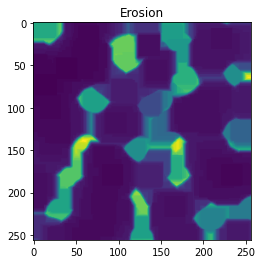

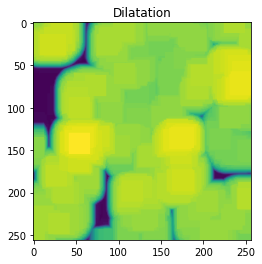

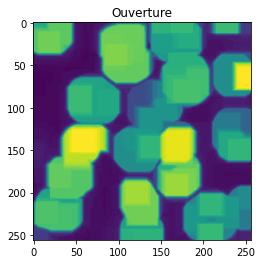

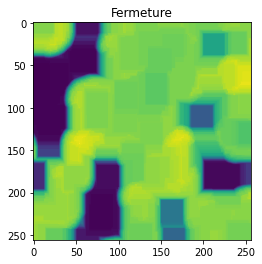

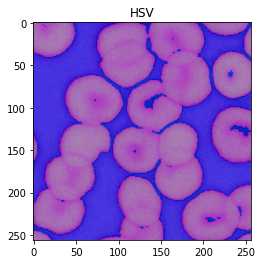

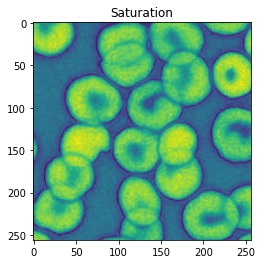

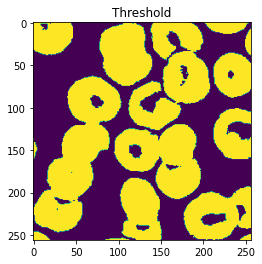

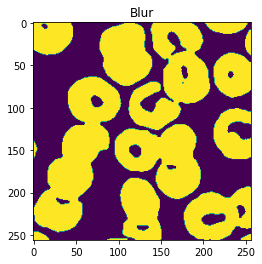

<ipython-input-38-d07fbead83ae>:38: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=40, labels=thr)


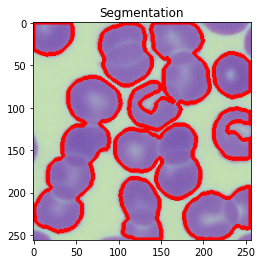

Number of blood cells segments detected =  7


In [38]:
img = cv2.imread('../dataset/training/image-10.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.invert(gray)

kernel = np.ones((25,25),np.uint8)
erosion = cv2.erode(gray,kernel,iterations = 1)
dilation = cv2.dilate(gray,kernel,iterations = 1)
opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

show(erosion, "Erosion")
show(dilation, "Dilatation")
show(opening, "Ouverture")
show(closing, "Fermeture")

# preprocessing the image
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
show(hsv,"HSV")

h, s, v = cv2.split(hsv)
show(s, "Saturation")

_, thr = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show(thr, "Threshold")

blur = cv2.medianBlur(thr, 5)
show(blur, "Blur")

contours, hierarchy = cv2.findContours(
    blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
count = []
for x in contours:
    area = cv2.contourArea(x)
    if area > 1000:
        count.append(x)

D = ndimage.distance_transform_edt(thr)
localMax = peak_local_max(D, indices=False, min_distance=40, labels=thr)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thr)
ws = len(np.unique(labels)) - 1

#Count number of segmentation
ans = int((ws + len(count)) / 2)
cv2.drawContours(img, count, -1, (255, 0, 0), 3)
show(img, "Segmentation")
print("Number of blood cells segments detected = ", ans)